In [1]:
%load_ext autoreload
%autoreload 2
%pip install scikit-learn



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import importlib
from sklearn.preprocessing import MinMaxScaler

import sys
import os
sys.path.append(os.path.abspath("../"))
from btc_forecast.data_loader import load_or_download
from btc_forecast.models_torch.registry import get_model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import json

import numpy as np
from btc_forecast.data_loader import load_or_download
from btc_forecast.data_processing import train_test, normalize
from btc_forecast.windowed_dataset import WindowedDataset
from btc_forecast.models_torch.registry import get_model
from config import config, models_config


In [3]:
def save_loss_plot(train_l, val_l, filename):
    plt.figure()
    plt.plot(train_l, label='Train Loss')
    plt.plot(val_l, label='Validation Loss')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import matplotlib.pyplot as plt

def preview_training_data(dataset, variables_used , num_samples=3):
    fig, axs = plt.subplots(num_samples, 1, figsize=(12, 4 * num_samples), sharex=True)

    for i in range(num_samples):
        x, y = dataset[i]
        x_np = x.numpy()
        y_np = y.numpy()

        for feature_idx in range(x_np.shape[1]):
            axs[i].plot(x_np[:, feature_idx], label=f'X: {variables_used[feature_idx]}', linestyle='-')

        for feature_idx in range(y_np.shape[1]):
            axs[i].plot(
                range(x_np.shape[0], x_np.shape[0] + y_np.shape[0]),
                y_np[:, feature_idx],
                label=f'Y: {variables_used[feature_idx]}',
                linestyle='--'
            )

        axs[i].legend()
        axs[i].set_title(f"Sample {i + 1}")
        axs[i].set_xlabel("Time step")
        axs[i].set_ylabel("Normalized Value")

    plt.tight_layout()
    plt.show()


Variables: ['close'], Input Width: 100, Label Width: 6, Batch Size: 32, Learning Rate: 0.001, Num Epochs: 50, Windows Normalization Length: 30
Variables: ['close'], Input Width: 100, Label Width: 6, Batch Size: 32, Learning Rate: 0.001, Num Epochs: 50, Windows Normalization Length: 30
📁 Loading BTCUSDT from /home/alice/btc_forecast/Data/BTCUSDT.csv
          close
35    -1.555025
36    -1.370331
37    -2.287014
38    -3.493231
39    -3.140549
...         ...
66790  0.239060
66791 -0.086361
66792 -0.385648
66793 -1.317938
66794 -1.109293

[66760 rows x 1 columns]


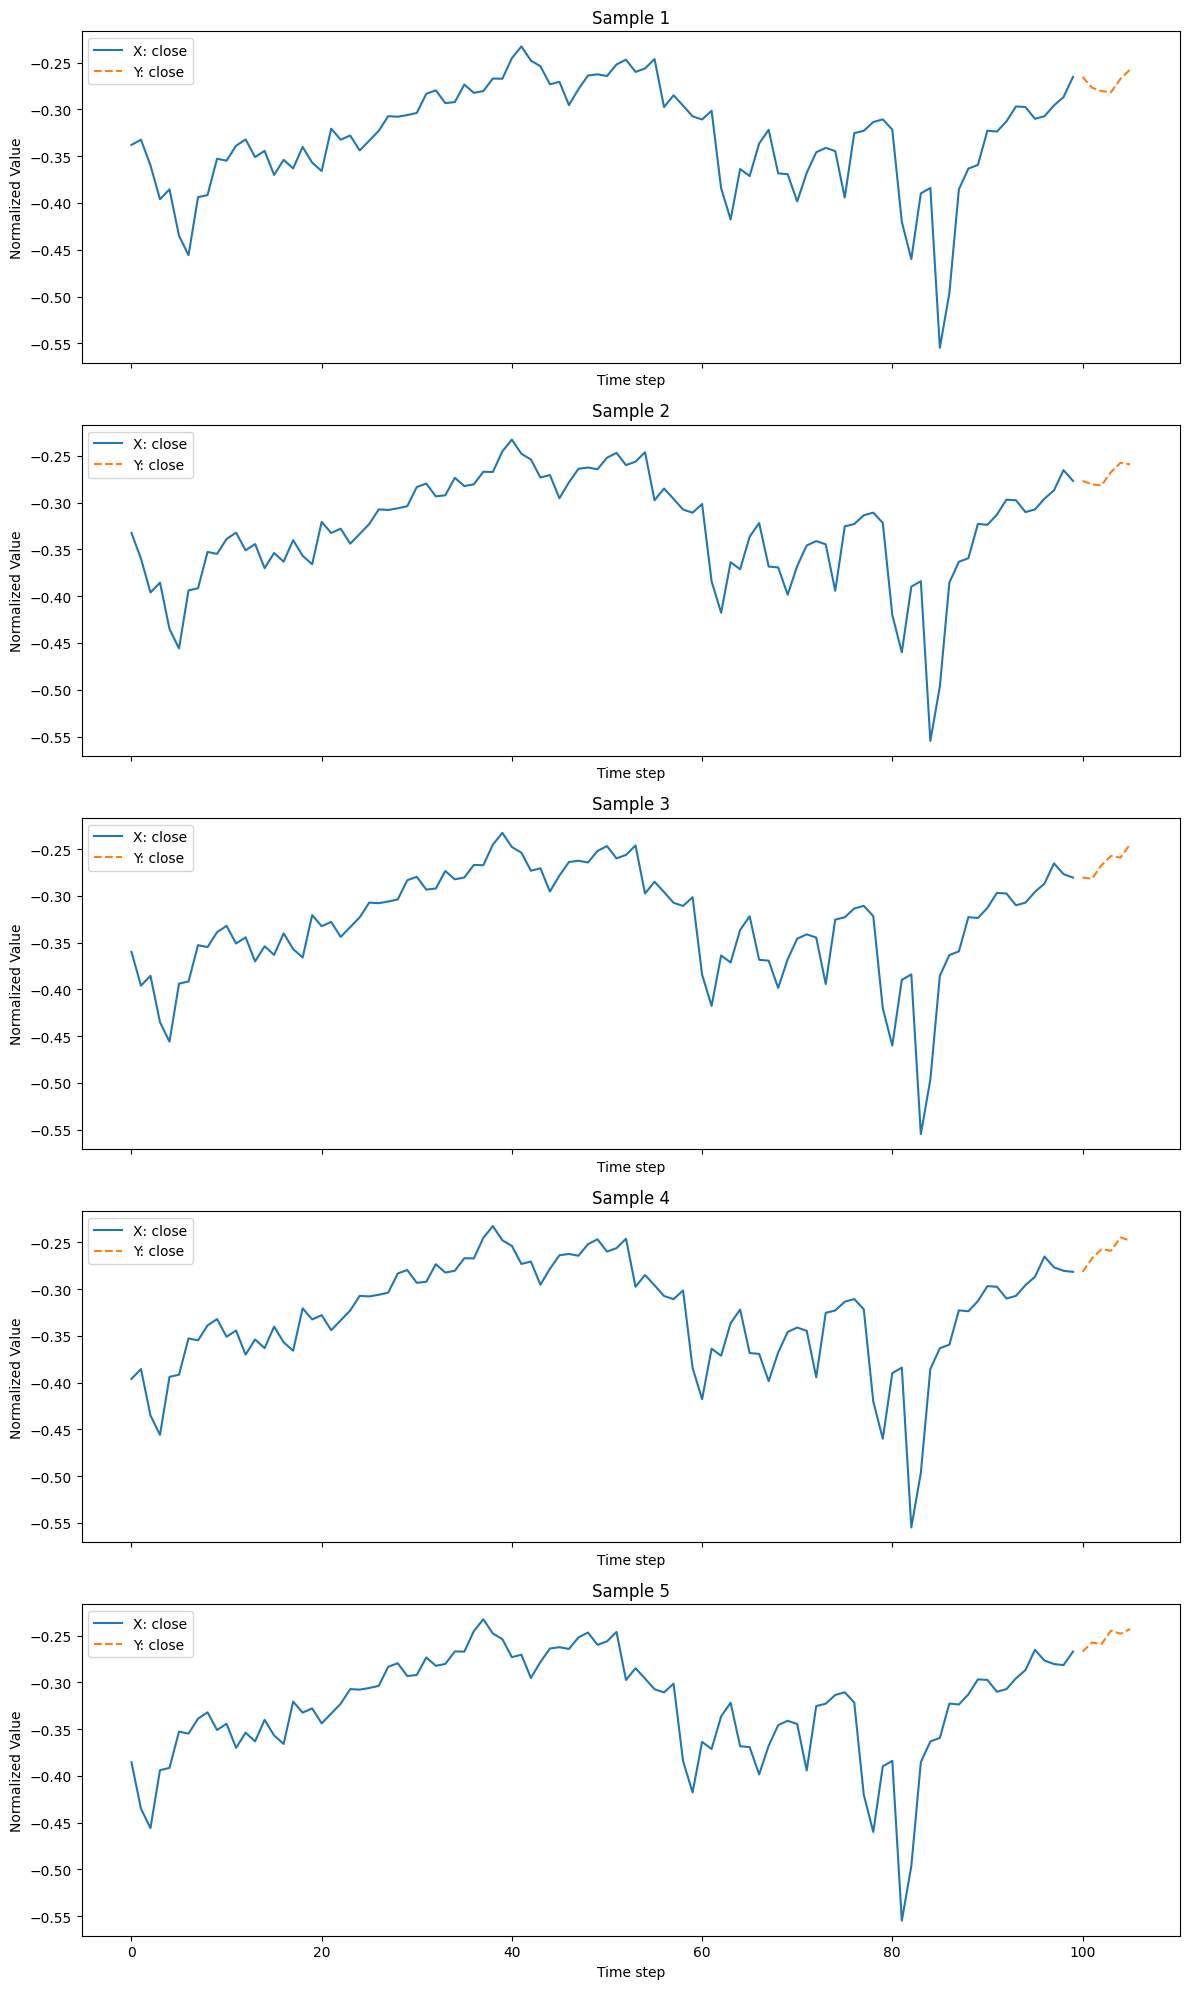

<bound method Module.parameters of ConvFC(
  (conv): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=6, bias=True)
  )
)>
📉 Epoch 1: Train=0.0033 | Val=0.0023
📉 Epoch 2: Train=0.0020 | Val=0.0021
📉 Epoch 3: Train=0.0018 | Val=0.0020
📉 Epoch 4: Train=0.0018 | Val=0.0021
📉 Epoch 5: Train=0.0018 | Val=0.0019
📉 Epoch 6: Train=0.0017 | Val=0.0018
📉 Epoch 7: Train=0.0017 | Val=0.0019
📉 Epoch 8: Train=0.0017 | Val=0.0019
📉 Epoch 9: Train=0.0017 | Val=0.0019
📉 Epoch 10: Train=0.0017 | Val=0.0019
📉 Epoch 11: Train=0.0017 | Val=0.0019
🛑 Early stopping
<bound method Module.parameters of ConvFC(
  (conv): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=6, bias=True)
  )
)>
📁 Loading BTCUSDT from /home/alice/btc_forecas

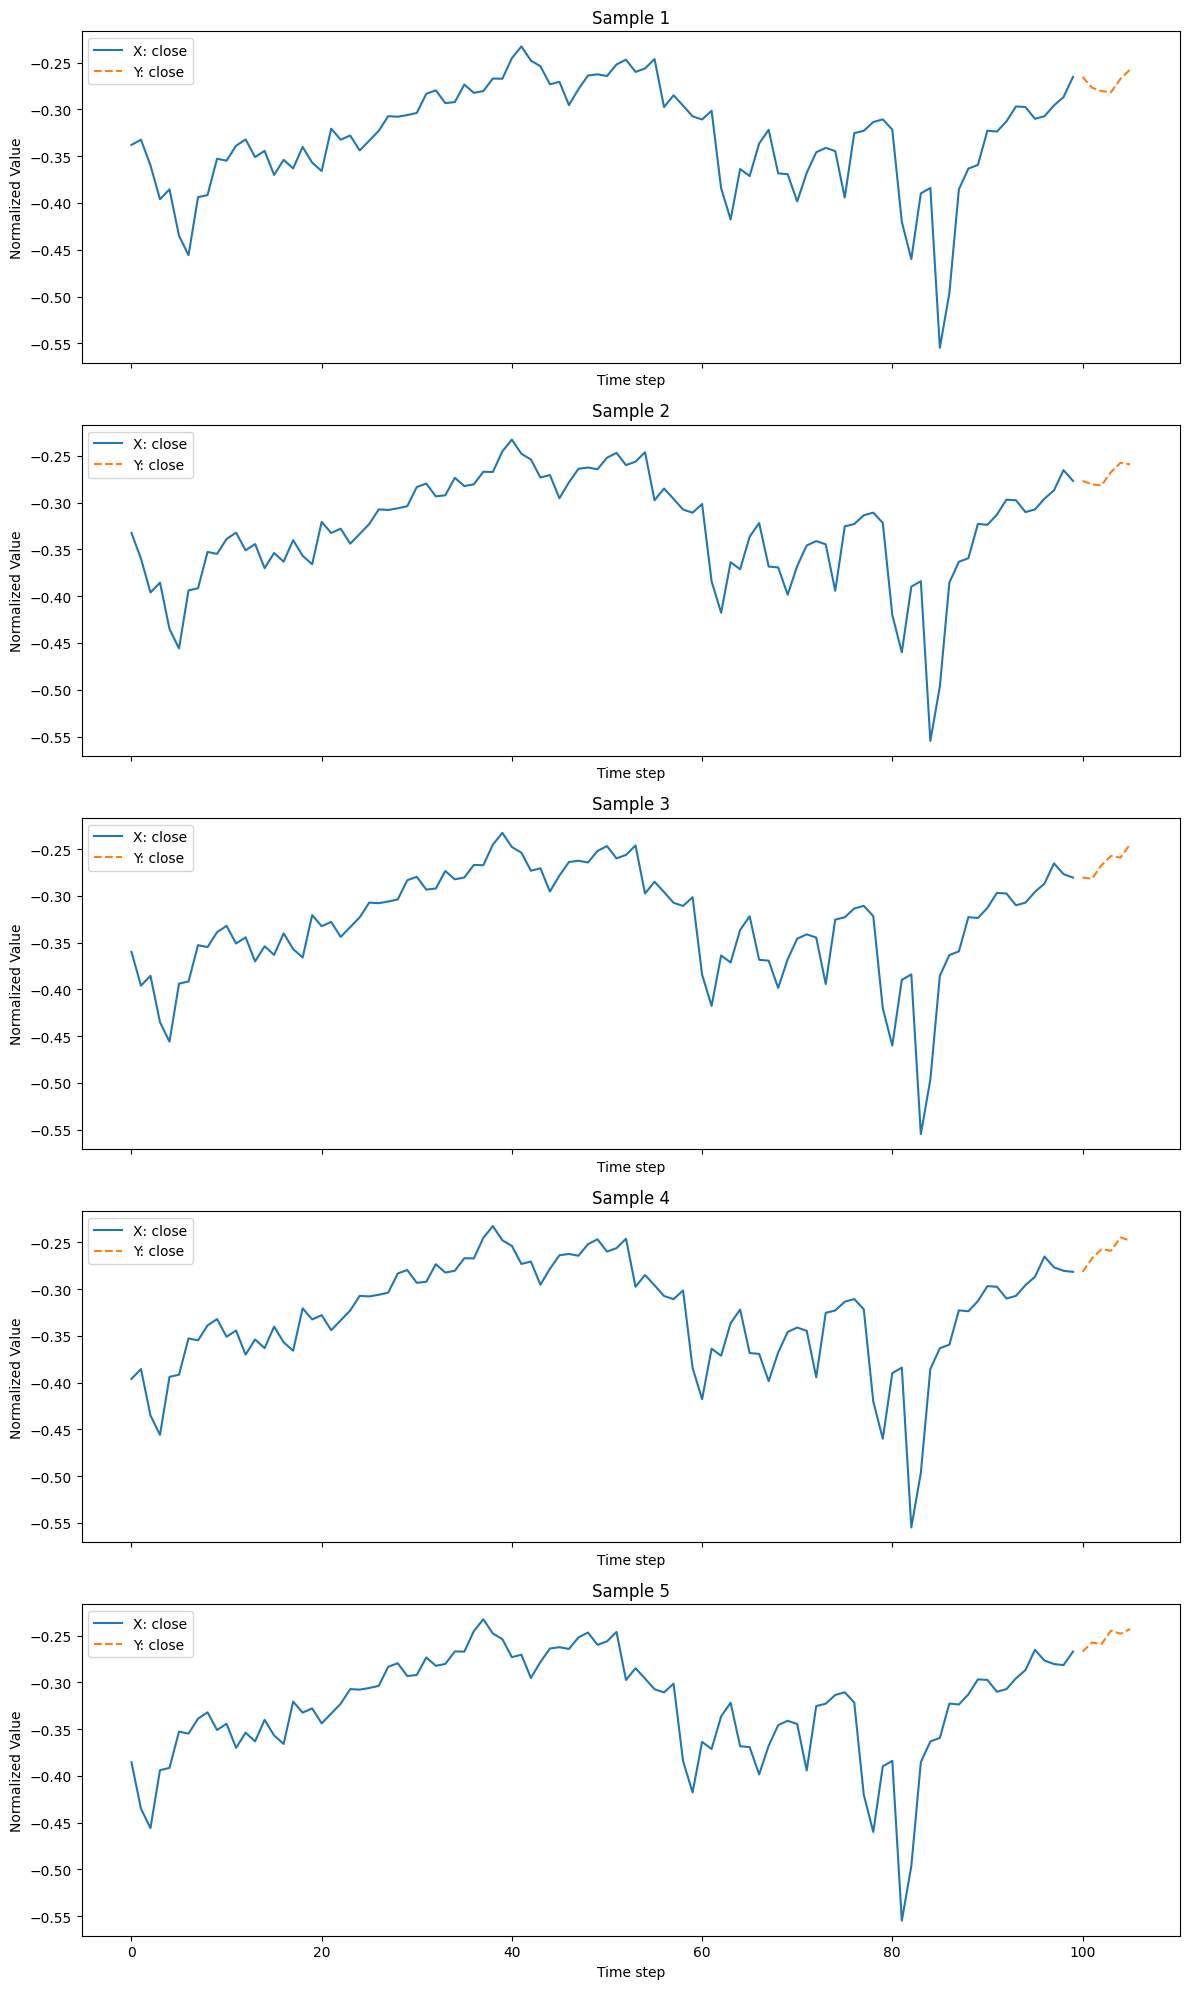

<bound method Module.parameters of SimpleFC(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)>


NotImplementedError: Module [SimpleFC] is missing the required "forward" function

In [ ]:
from itertools import combinations, product
models =[]

base_features = ['close', 'open', 'high', 'low', 'volume']
variable_sets = [list(c) for i in range(1, len(base_features)+1) for c in combinations(base_features, i)]


# Hyperparameter grid
param_grid = {
    "input_width": [100, 200],
    "label_width": [6, 12, 24],
    "batch_size": [32, 64],
    "learning_rate": [0.001, 0.0005],
    "num_epochs": [50],  # can expand later
    "windows_normalization_length": [30 ,15],
}

all_combinations = list(product(
    variable_sets,
    param_grid["input_width"],
    param_grid["label_width"],
    param_grid["batch_size"],
    param_grid["learning_rate"],
    param_grid["num_epochs"],
    param_grid["windows_normalization_length"]
))

for (variables_used, input_width, label_width, batch_size,
     learning_rate, num_epochs, windows_normalization_length) in all_combinations:

    print(f"Variables: {variables_used}, Input Width: {input_width}, Label Width: {label_width}, "
          f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Num Epochs: {num_epochs}, "
          f"Windows Normalization Length: {windows_normalization_length}")
    # Load the model

    close_idx = variables_used.index("close")
    coin="BTCUSDT"
    ## SImple Linear 
    model_config = {
    "input_width": input_width,
    "label_width": label_width,
    "num_features": len(variables_used),
    "conv_channels": 16,        # NEW
    "kernel_size": 3            # NEW
        }
    class ConvFC(nn.Module):

        def __init__(self, input_width, label_width, num_features, conv_channels=16, kernel_size=3):
            super(ConvFC, self).__init__()

            self.input_width = input_width
            self.label_width = label_width
            self.num_features = num_features
            self.conv_channels = conv_channels
            self.kernel_size = kernel_size

            conv_output_width = input_width - kernel_size + 1
            input_dim = conv_output_width * conv_channels
            output_dim = label_width * num_features

            self.conv = nn.Conv1d(
                in_channels=num_features,
                out_channels=conv_channels,
                kernel_size=kernel_size
            )

            self.fc = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Linear(128, output_dim)
            )

        def forward(self, x):
            # x: (batch_size, input_width, num_features)
            x = x.permute(0, 2, 1)        # → (batch_size, num_features, input_width)
            x = self.conv(x)              # → (batch_size, conv_channels, output_width)
            x = x.flatten(start_dim=1)    # → (batch_size, conv_channels * output_width)
            x = self.fc(x)                # → (batch_size, label_width * num_features)
            return x.view(-1, self.label_width, self.num_features)

    models.append(ConvFC(**model_config))

    model_config = {
        "input_width": input_width,
        "label_width": label_width,
        #"hidden_size": 64,
        #"num_layers": 2,
        "num_features": len(variables_used),
        }
    class SimpleFC(nn.Module):
        def __init__(self, input_width, label_width, num_features):
            super(SimpleFC, self).__init__()
            self.input_width = input_width
            self.label_width = label_width
            self.num_features = num_features
            input_dim = input_width * num_features
            output_dim = label_width * num_features

            self.fc = nn.Sequential(
                nn.Flatten(start_dim=1),
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Linear(128, output_dim)
            )
        def forward(self, x):
            x = self.fc(x)                             # → (batch_size, label_width * num_features)
            return x.view(-1, self.label_width, self.num_features) 
    models.append(SimpleFC(**model_config))
    #GRU
    model_config = {
        "input_width": input_width,
        "label_width": label_width,
        "hidden_size": 64,
        "num_layers": 2,
        "num_features": len(variables_used),
        }
    class GRUStacked(nn.Module):
        def __init__(self, input_width, label_width, num_features, hidden_size=64, num_layers=2):
            super(GRUStacked, self).__init__()
            self.gru = nn.GRU(
                input_size=num_features,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True
            )
            self.fc = nn.Linear(hidden_size, label_width * num_features)
            self.label_width = label_width
            self.num_features = num_features

        def forward(self, x):
            out, _ = self.gru(x)
            out = out[:, -1, :]  # take the output from the last timestep
            out = self.fc(out)
            return out.view(-1, self.label_width, self.num_features)
    models.append(GRUStacked(**model_config))

    ## Transormer
    model_config = {
        "input_width": input_width,
        "label_width": label_width,
        "hidden_size": 64,
        "num_layers": 2,
        "num_features": len(variables_used),
        }

    class TransformerTimeSeries(nn.Module):
        def __init__(self, input_width, label_width, num_features, hidden_size=64, num_layers=3, nhead=4):
            super(TransformerTimeSeries, self).__init__()
            self.input_width = input_width
            self.label_width = label_width
            self.num_features = num_features
            self.hidden_size = hidden_size

            self.input_projection = nn.Linear(num_features, hidden_size)

            self.positional_encoding = nn.Parameter(torch.randn(1, input_width, hidden_size))

            encoder_layer = nn.TransformerEncoderLayer(
                d_model=hidden_size,
                nhead=nhead,
                dim_feedforward=hidden_size * 4,
                dropout=0.1,
                batch_first=True
            )
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

            self.output_layer = nn.Linear(hidden_size, label_width * num_features)

        def forward(self, x):
            # x shape: (batch_size, input_width, num_features)
            x = self.input_projection(x)  # (batch_size, input_width, hidden_size)
            x = x + self.positional_encoding[:, :x.size(1), :]  # Add positional encoding

            encoded = self.transformer_encoder(x)  # (batch_size, input_width, hidden_size)
            last_token = encoded[:, -1, :]  # Take the last time step
            out = self.output_layer(last_token)  # (batch_size, label_width * num_features)

            return out.view(-1, self.label_width, self.num_features)
    models.append(TransformerTimeSeries(**model_config))

    #TRAN THE MODEL 

    def train_model(
        coin,
        model,
        input_width=200,
        label_width=12,
        lr=1e-3,
        max_epochs=num_epochs,
        patience=5,
        
    ):

    

        df = load_or_download(coin)
        #if 'volume' in df.columns:
        #    df["volume"] = np.log1p(df["volume"])
        #df_norm = normalize(df, label_width=label_width, window=30)
        df_norm = normalize(df[variables_used], label_width=label_width, window=windows_normalization_length)

        print(df_norm)
        scaler = MinMaxScaler(feature_range=(-1, 1))
        df_norm[df_norm.columns] = scaler.fit_transform(df_norm)

        train_df, val_df, _ = train_test(df_norm)

        train_ds = WindowedDataset(train_df, input_width, label_width, 0, variables_used)
        preview_training_data(train_ds, variables_used, num_samples=5)


        val_ds = WindowedDataset(val_df, input_width, label_width, 0, variables_used)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
        print( model.parameters)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        train_losses, val_losses = [], []
        best_val_loss = float("inf")
        best_weights = None
        early_stop_counter = 0

        



        for epoch in range(max_epochs):
            model.train()
            running_loss = 0.0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = loss_fn(preds, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            train_loss = running_loss / len(train_loader)
            train_losses.append(train_loss)

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    preds = model(xb)
                    val_loss += loss_fn(preds, yb).item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            print(f"📉 Epoch {epoch+1}: Train={train_loss:.4f} | Val={val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = model.state_dict()
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print("🛑 Early stopping")
                    break

        return model, best_weights, train_losses, val_losses , scaler
    print(f"Variables: {variables_used}, Input Width: {input_width}, Label Width: {label_width}, "
          f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Num Epochs: {num_epochs}, "
          f"Windows Normalization Length: {windows_normalization_length}")
    output_dir = "reports"
    os.makedirs(output_dir, exist_ok=True)
    summary_path = os.path.join(output_dir, "summary_metrics.csv")
    if not os.path.exists(summary_path):
        pd.DataFrame(columns=[
            "MAE/step", "RMSE/step", "Model", "Model Arch", "Coin", "Input Width", "Label Width",
            "Batch Size", "Learning Rate", "Num Epochs", "Windows Normalization Length",
            "Train Loss", "Validation Loss" , "Features"
        ]).to_csv(summary_path, index=False)
    loss_path = os.path.join(output_dir, f"loss.png")
    for model in models:
        model.to(device)
        model, weights, train_l, val_l , scaler= train_model(
            coin=coin,
            model=model,
            input_width=input_width,
            label_width=label_width,
            lr=learning_rate,
            max_epochs=num_epochs,
            patience=5
        )
        print(model.parameters)

        save_loss_plot(train_l, val_l, loss_path)

        # Optionally save
        #torch.save(weights, "models/ConvDenseTorch_BTCUSDT_best.pt")
        import pandas as pd
        df = load_or_download(coin)

        _, _, validate_raw = train_test(df[variables_used])

        # Normalize test data
        test_df_zscore = normalize(validate_raw, label_width, window=windows_normalization_length)

        test_df_scaled = scaler.transform(test_df_zscore)
        test_df_scaled = pd.DataFrame(
            test_df_scaled,
            columns=test_df_zscore.columns,  # or variables_used
            index=test_df_zscore.index       # optional but nice to keep alignment
        )
        test_ds = WindowedDataset(test_df_scaled, input_width, label_width, 0,variables_used)
        test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)
        # Here make predictions on test data
        model.eval()
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                all_preds.append(pred.cpu().numpy())
                all_targets.append(yb.cpu().numpy()) 


        all_preds = np.concatenate(all_preds, axis=0)  # (num_windows, label_width, num_features)
        all_targets = np.concatenate(all_targets, axis=0)
        # Extract only 'close'
        preds_minmax = all_preds[:, :, close_idx]
        targets_minmax = all_targets[:, :, close_idx]

        # Reshape to 2D for scaler
        preds_flat = preds_minmax.reshape(-1, 1)
        targets_flat = targets_minmax.reshape(-1, 1)

        close_min = scaler.data_min_[close_idx]
        close_max = scaler.data_max_[close_idx]

        # Manually invert MinMax: x = (scaled + 1) / 2 * (max - min) + min
        preds_zscore = 0.5 * (preds_minmax + 1) * (close_max - close_min) + close_min
        targets_zscore = 0.5 * (targets_minmax + 1) * (close_max - close_min) + close_min

        denorm_preds = np.zeros_like(preds_zscore)
        denorm_targets = np.zeros_like(targets_zscore)
        for i in range(preds_zscore.shape[0]):
            for j in range(label_width):
                idx = i + j + input_width  # alignment

                mean = validate_raw["close"].shift(label_width).rolling(window=windows_normalization_length).mean().iloc[idx]
                std = validate_raw["close"].shift(label_width).rolling(window=windows_normalization_length).std().iloc[idx]

                denorm_preds[i, j] = preds_zscore[i, j] * std + mean
                denorm_targets[i, j] = targets_zscore[i, j] * std + mean
        from sklearn.metrics import mean_absolute_error, mean_squared_error

        mae = mean_absolute_error(denorm_targets.flatten(), denorm_preds.flatten())
        rmse = np.sqrt(mean_squared_error(denorm_targets.flatten(), denorm_preds.flatten()))
        model_arch = str(model).replace('\n', '; ').strip()[:300] 
        row_df = pd.DataFrame([{
        "MAE/step": mae / label_width,
        "RMSE/step": rmse / label_width,
        "Model": model.__class__.__name__,
        "Model Arch": model_arch,
        "Coin": coin,
        "Input Width": input_width,
        "Label Width": label_width,
        "Batch Size": batch_size,
        "Learning Rate": learning_rate,
        "Num Epochs": num_epochs,
        "Windows Normalization Length": windows_normalization_length,
        "Train Loss": train_l[-1],
        "Validation Loss": val_l[-1],
        "Features": ",".join(variables_used),
        }])
        row_df.to_csv(summary_path, mode='a', header=False, index=False)
        print(f"✅ Final MAE: {mae:.2f}")
        print(f"✅ Final RMSE: {rmse:.2f}")

In [ ]:
output_dir = "reports"
os.makedirs(output_dir, exist_ok=True)
summary_path = os.path.join(output_dir, "summary_metrics.csv")
if not os.path.exists(summary_path):
    pd.DataFrame(columns=[
        "MAE", "RMSE", "Model", "Model Arch", "Coin", "Input Width", "Label Width",
        "Batch Size", "Learning Rate", "Num Epochs", "Windows Normalization Length",
        "Train Loss", "Validation Loss"
    ]).to_csv(summary_path, index=False)
loss_path = os.path.join(output_dir, f"loss.png")
for model in models:
    print(model)
    model.to(device)
    model, weights, train_l, val_l , scaler= train_model(
        coin=coin,
        model=model,
        input_width=input_width,
        label_width=label_width,
        lr=leraning_rate,
        max_epochs=num_epochs,
        patience=5
    )
    print(model.parameters)

    save_loss_plot(train_l, val_l, loss_path)

    # Optionally save
    #torch.save(weights, "models/ConvDenseTorch_BTCUSDT_best.pt")
    import pandas as pd
    df = load_or_download(coin)

    def train_test(df):
        n = len(df)
        train_df = df[0:int(n*0.7)]
        val_df = df[int(n*0.7):int(n*0.9)]
        test_df = df[int(n*0.9):]

        return train_df, val_df, test_df


    _, _, validate_raw = train_test(df[variables_used])

    # Normalize test data
    test_df_zscore = normalize(validate_raw, label_width, window=windows_normalization_length)

    test_df_scaled = scaler.transform(test_df_zscore)
    test_df_scaled = pd.DataFrame(
        test_df_scaled,
        columns=test_df_zscore.columns,  # or variables_used
        index=test_df_zscore.index       # optional but nice to keep alignment
    )
    test_ds = WindowedDataset(test_df_scaled, input_width, label_width, 0,variables_used)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)
    # Here make predictions on test data
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            all_preds.append(pred.cpu().numpy())
            all_targets.append(yb.cpu().numpy()) 


    all_preds = np.concatenate(all_preds, axis=0)  # (num_windows, label_width, num_features)
    all_targets = np.concatenate(all_targets, axis=0)
    # Extract only 'close'
    preds_minmax = all_preds[:, :, close_idx]
    targets_minmax = all_targets[:, :, close_idx]

    # Reshape to 2D for scaler
    preds_flat = preds_minmax.reshape(-1, 1)
    targets_flat = targets_minmax.reshape(-1, 1)

    close_min = scaler.data_min_[close_idx]
    close_max = scaler.data_max_[close_idx]

    # Manually invert MinMax: x = (scaled + 1) / 2 * (max - min) + min
    preds_zscore = 0.5 * (preds_minmax + 1) * (close_max - close_min) + close_min
    targets_zscore = 0.5 * (targets_minmax + 1) * (close_max - close_min) + close_min

    denorm_preds = np.zeros_like(preds_zscore)
    denorm_targets = np.zeros_like(targets_zscore)
    for i in range(preds_zscore.shape[0]):
        for j in range(label_width):
            idx = i + j + input_width  # alignment

            mean = validate_raw["close"].shift(label_width).rolling(window=windows_normalization_length).mean().iloc[idx]
            std = validate_raw["close"].shift(label_width).rolling(window=windows_normalization_length).std().iloc[idx]

            denorm_preds[i, j] = preds_zscore[i, j] * std + mean
            denorm_targets[i, j] = targets_zscore[i, j] * std + mean
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    mae = mean_absolute_error(denorm_targets.flatten(), denorm_preds.flatten())
    rmse = np.sqrt(mean_squared_error(denorm_targets.flatten(), denorm_preds.flatten()))
    model_arch = str(model).replace('\n', '; ').strip()[:300] 
    row_df = pd.DataFrame([{
    "MAE": mae,
    "RMSE": rmse,
    "Model": model.__class__.__name__,
    "Model Arch": model_arch,
    "Coin": coin,
    "Input Width": input_width,
    "Label Width": label_width,
    "Batch Size": batch_size,
    "Learning Rate": leraning_rate,
    "Num Epochs": num_epochs,
    "Windows Normalization Length": windows_normalization_length,
    "Train Loss": train_l[-1],
    "Validation Loss": val_l[-1],
    }])
    row_df.to_csv(summary_path, mode='a', header=False, index=False)
    print(f"✅ Final MAE: {mae:.2f}")
    print(f"✅ Final RMSE: {rmse:.2f}")


In [ ]:
import matplotlib.pyplot as plt
n_charts = 10
for i in range( 0, len(denorm_preds), len(denorm_preds)//n_charts):
    plt.figure(figsize=(6, 4))
    plt.plot(denorm_targets[i], label="Real Close", color="blue")
    plt.plot(denorm_preds[i], label="Predicted Close", color="orange")
    plt.title(f"Prediction Window {i+1}")
    plt.xlabel("Forecast Step")
    plt.ylabel("Close Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

